# Ensembles
This notebook is setup to run ensemble simulations

Stipulations for ensembles:
- no seasonality
- run monthly
- Aquaseca's notebook was our base model

Parameter Values
- 1. K1, K2, and K3 = [5, 25, 100] # baseline Kx=Ky=Kz value in all zones (m/day)
- 2. Kz ratio_lowK = [1e-6, 1e-2, 1] # ratio of Kz in low-K layer to baseline K (-)
- 3. Sy = [0.05, 0.1, 0.3] # specific yield (-)
- 4. R_mountains = [1e-5, 3e-5, 5e-5] # recharge rate in mountains (m/day)
- 5. ET_valley = [1e-6, 1e-5, 1e-4] # ET rate in valley (m/day)
- 6. ETratio_riparian = [1, 2, 3] # ratio of ET in riparian area to ET rate in valley (m/day)
- 7. Kratio_streambed = [1e-2,1e-1, 1] # ratio of K in streambed to baseline K (-)


# 1. Packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

# 2. Discretization and other inputs that don't change

In [2]:
#modflow dir
moddir = "C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe"

# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # elevation of top layer (import from csv file) (dim: nrow,ncol)

## set the bottom elevations of every layer
botm = np.zeros((nlay, nrow, ncol))
botm[2, :, :] = 0
botm[1, :, :] = 40              # bottom elevation of middle layer (1) is 40 m
botm[0, :, :] = 45              # bottom elevation of top layer (0) 45

# Boundary conditions
h_right = 70  #right side constant head 70m

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
uncnf = 1       #0=confined, >0 = unconfined

#TOWN supply well
pumping = -1500 #m3/day 
well_row = 21
well_col = 38
well_loc = (2,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
print("Town well location(layer, col, row)",2, well_row, well_col)

#irrigation well (ag pumping)
pumping_irr = -4500 #m3/day 
welli_row = 12 
welli_col = 14 

#CHANGED LAYER FROM 0 TO 2
welli_loc = (2,welli_row, welli_col)
welli = [2,welli_row, welli_col, pumping_irr] 
print("Irrigation well location(layer, col, row)", 2, welli_row, welli_col)

# Agricultural recharge rate
agrech = 0.00015  # pistachios (1/8th area already included)

# ET extinction depth
extinction_depth = 10  # m

# River
sed_thick = 1  # thickness of riverbed sediment in m
r_stage = .5  # stage in river (stress period 1)
r_bott = ztop[24, :]  # river bottom

# Stress periods
p_peryr = 1  # number of stress periods per year
sp_len = 360  # length of a stress period
sim_years = 2  #number of simulation years to run
nper = int(p_peryr*sim_years)+1  #total number of stress periods
steady = np.ones(nper, dtype=bool)*False #steady state array 
steady[0] = True    # initial stress period is steady-state
perlen = np.tile([sp_len], sim_years+1)  # make an array of period lengths
nstp = perlen/30  # # of time steps to solve within each period (/30 for monthly here)
nstp = nstp.astype(int)


Town well location(layer, col, row) 2 21 38
Irrigation well location(layer, col, row) 2 12 14


 ## 3. Esemble variables and ensembles to run

In [3]:
ensembles = [[1,1,1,1,3,3,1],
[1,2,2,1,1,2,2], 
[2,1,3,3,2,1,3],
[2,2,2,2,3,3,3],
[2,1,3,3,1,2,2],
[2,2,3,3,1,1,2],
[2,1,1,2,2,2,3],
[2,2,3,3,2,1,1],
[2,1,2,3,2,2,1],
[3,3,3,3,3,3,3]]
n_ens = len(ensembles)
print(n_ens, 'Ensembles to run')

#Ensemble Variables -- in the order they are listed
k_list = [5,25,100]
kratio_list  = [1e-6,1e-2, 1]
sy_list = [0.05, 0.1, 0.3]
rmountain_list = [1e-5, 3e-5, 5e-5]
etvalley_list = [1e-6, 1e-5, 1e-4]
etratio_list = [1,2,3]
streamk_list = [1e-2, 1e-1,1]

10 Ensembles to run


## 4. Inital and Boundary Conditions

In [4]:
# Initial and boundary conditions
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

# 5. Run Modflow

In [5]:
#Loop over the ensemble list and run the model
for ens_run in range(n_ens):
    #ens_run = 0  # picking one ensemble member

    ############################
    #create model object and name
    ############################
    name = "ensemble_"
    ensemble_pick=ensembles[ens_run]
    for p in range(7):
        string = str(ensemble_pick[p])
        name = name + string
    modelname = name
    m = flopy.modflow.Modflow(modelname, exe_name = moddir)
    
    ############################
    # Discritization
    ############################
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                                   delr=dx, delc=dy, top=ztop, botm=botm, 
                                   itmuni = 4, lenuni = 2, 
                                   nper=nper, steady=steady, perlen=perlen, nstp=nstp)
    
    ############################
    # Boundary and initial conditions - bas
    ############################
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)
    
    ############################
    #Layer properties - lpf
    ############################
    ## Get the desired Sy and K values for the ensemble
    K_horiz = k_list[(ensembles[ens_run][0]-1)]
    K_vert = k_list[(ensembles[ens_run][0]-1)]
    K_horiz2 = K_horiz * kratio_list[(ensembles[ens_run][1]-1)]
    K_vert2 = K_vert * kratio_list[(ensembles[ens_run][1]-1)]
    Sy = sy_list[(ensembles[ens_run][2]-1)]
    ## setup arrays
    Kh = np.zeros((nlay, nrow, ncol))
    Kh[:, :, :] = K_horiz  # assign the original value to the entire array
    Kz = np.zeros((nlay, nrow, ncol))
    Kz[:, :, :] = K_vert
    Kz[1, :, 20:49] = K_vert2  # Replace K in the middle layer with the lower value
    ## setup lpf package
    lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                                   vka=Kz, ss=Ss,
                                   sy=Sy,storagecoefficient=True, ipakcb=53)
    
    ############################
    #ET - evt
    ############################
    ## Get ET values from the ensemble
    ET = etvalley_list[(ensembles[ens_run][4]-1)]
    rip_ET = ET * etratio_list[(ensembles[ens_run][5]-1)]
    ## setup ET array and dictionary
    ET_zone = np.zeros((1, nrow, ncol))
    ET_zone[0, :, 25:] = ET   #first layer, all rows, columns 25 to right boundary
    ET_zone[0, 21:28, :] = rip_ET
    ET_dict = {}  # set up an ET dictionary, where each key is a stress period num 0-50
    for p in range(0, nper):  # loop over stress periods, odds are 0 ET, evens are reg ET
        ET_dict[p] = ET_zone
    ## setup evt package
    evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_dict, exdp=extinction_depth, ipakcb=53) 

    ############################
    #Recharge - rch
    ############################
    ## Get recharge values from the ensemble
    rech = rmountain_list[(ensembles[ens_run][3]-1)]
    ## setup Recharge array and dictionary
    rech_zone_forced = np.zeros((1, nrow, ncol))
    rech_zone_forced[0, :, 0:15] = rech  # natural regcharge
    rech_zone_with_ag = rech_zone_forced.copy()
    rech_zone_with_ag[0, 20:22, 18:20] = agrech  # agricultural recharge
    rech_dict = {}
    for i in range(nper):  # loop over stress periods, odds are 0 ET, evens are reg ET
        rech_dict[i] = rech_zone_with_ag
    ## setup recharge package
    rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_dict, ipakcb=53)     #create rch object

    ############################
    #River - riv
    ############################
    # Get streambed K ratio from ensembe and calculate conductance
    stream_ratio = streamk_list[(ensembles[ens_run][6]-1)]
    k_rivbott = K_vert * stream_ratio
    cond = k_rivbott*(1)*(1000)/(sed_thick)  # river bed conductance in m^2/d
    ## setup river array and dictionary
    riv_sp = []  # create list to store all river cells for stress period 1
    for i in range(1, ncol):
        riv_sp.append([0, 24, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    riv_spd = {0: riv_sp}
    ## setup riv package
    riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=   53)

    ############################
    #Well - wel
    ############################
    ## setup wel dictionary
    wel_spd = {}
    for strper in range(0, nper):
        wel_spd[strper] = [[2, well_row, well_col, pumping],
                       [2, welli_row, welli_col, pumping_irr]] #CHANGED FROM 0 TO 2
    ## setup wel package
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

    ############################
    #Output control - OC 
    ############################
    oc_spd = {}
    for kper in range(0, nper):
        for kstp in range(nstp[kper]):
            oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

    ############################
    #Numerical solver - pcg
    ############################
    pcg = flopy.modflow.ModflowPcg(model=m, mxiter=5000, iter1=500, relax = 0.97, damp = 0.01)

    ############################
    #write the inputs
    ############################
    m.write_input()   

    ############################
    # Run checks
    ############################
    #m.oc.check()
    #m.oc.check()
    #m.lpf.check()
    #m.riv.check()
    #m.rch.check()
    #m.dis.check()

    ############################
    #Run the model 
    ############################
    #Select variables given ensemble number i
    print('Running Ensemble Run:',  ens_run, ' (', name, ')')
    print('K Upper and Lower:', K_horiz, "Middle K:", K_vert2)
    print('Specific Yield:', Sy, "Mountain Recharge:", rech)
    print('Valley ET:', ET, "Riparian ET:", np.round(rip_ET,2),
          "streambed K ratio:", stream_ratio)

    success, mfoutput = m.run_model(pause=False, report=True)
    if not success:
        raise Exception('MODFLOW did not terminate normally.')


Running Ensemble Run: 0  ( ensemble_1111331 )
K Upper and Lower: 5 Middle K: 4.9999999999999996e-06
Specific Yield: 0.05 Mountain Recharge: 1e-05
Valley ET: 0.0001 Riparian ET: 0.0 streambed K ratio: 0.01
FloPy is using the following executable to run the model: C:/Users/tento/Documents/GW_Modeling/homework-akahler03/Working/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: ensemble_1111331.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/05/02 14:55:13

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     1 

# 4. Plotting

### Domain grid

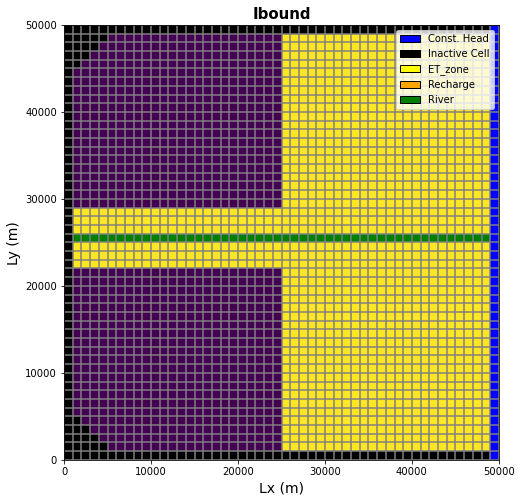

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
ET_plot = ET_zone.copy()
ET_plot[ET_zone>0]=1
rch_plot = rech_zone_with_ag.copy()
rch_plot[rch_plot>0]=1
#zone_plot=zone_plot+rch_plot

et_plotlayer = modelmap.plot_array(ET_plot)
#rch_plotlayer = modelmap.plot_array(rech_zone_with_ag)
riv_plotlayer = modelmap.plot_bc(ftype='RIV', color='green')
wel_plot = modelmap.plot_bc(ftype = 'WEL')
quadmesh = modelmap.plot_ibound()



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   #mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    #mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
                    mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')


### Read in heads

In [7]:
#setup well locations and observation points
well_loc = (2,21, 38) #town well 
welli_loc = (2,12, 14) #ag irrigation well 
#observation well
#wello_loc = (2, 15, 15)  # ag observation well we want this in top layer to observe the water table depth

#setup timeseries
head_ts = []  # timeseries of head at town well
ag_head_ts = []  # timeseries of head at agg well
#mw1_head_ts = []  # timeseries of head at observation well

# Loop through the ensembles and read the data
root_name = 'ensemble_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')

    head_ts.append(headobj.get_ts(well_loc))        #town well
    ag_head_ts.append(headobj.get_ts(welli_loc))    #ag well

    times = headobj.get_times()

In [8]:
#setup arrays to store the values
head_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))  #4D array with shape time, layer, col, row for each ensemble
frf_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))
fff_array = np.zeros((len(ensembles), len(times), nlay, ncol, nrow))
recharge_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))
et_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))
stor_array = np.zeros((len(ensembles), len(times), 1, ncol, nrow))

# Loop through the ensembles and read the data
root_name = 'ensemble_' #root of the run names
for i in range(len(ensembles)):
    name = root_name  #Create the file name from list 
    for k in range(len(ensembles[i])):
        string = str(ensembles[i][k])
        name = name + string   

    #read in the head and water budget files
    headobj = flopy.utils.binaryfile.HeadFile(name+'.hds')
    budgobj = flopy.utils.binaryfile.CellBudgetFile(name+'.cbc')   

    rowcounter = -1
    for t in times:
        rowcounter += 1
        head_array[i, rowcounter,:, :, :] = headobj.get_data(totim=t)
        
        tempfrf = np.squeeze(budgobj.get_data(text='flow right face', totim=t))
        frf_array[i, rowcounter,:, :, :] = tempfrf
        
        tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE', totim=t))
        fff_array[i, rowcounter,:, :, :] = tempfff

        temprch = np.squeeze(budgobj.get_data(text='RECHARGE', totim=t))
        recharge_array[i, rowcounter, :, :, :] = temprch[1]

        tempet = np.squeeze(budgobj.get_data(text='ET', totim=t))
        et_array[i, rowcounter, :, :, :] = tempet[1]
